1.1 Write functions to compute both the X and Y gradients. Try your code on both transA
and simA. To display the output, adjoin the two gradient images(X and Y) to make a new,
twice as wide, single image (the ”gradient-pair”). Since gradients have negaitve and positiive
values, you’ll need to produce and image that is gray for 0.0 and balck is negative and white
is positive. Take an analytic derivative of a Gaussian in X or Y and use that filtter

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.linalg import svd



In [3]:

#Analytical derivative of a Gaussian in X and apply it to an image
def gaussian_derivative_x(img,sigma,kernel_size):
    #Derivative in x direction
    kernel=cv2.getGaussianKernel(kernel_size,sigma, cv2.CV_64F)
    gaussian_derivative_x=np.zeros_like(kernel)
    assert(kernel_size%2==1) #kernel size must be odd
    half_kernel_size=int((kernel_size)/2) 
    for i in range(kernel_size):
        x=-half_kernel_size+i
        factor=-x/(sigma**2)
        gaussian_derivative_x[i]=kernel[i]*factor

    return (cv2.filter2D(img,-1,gaussian_derivative_x))    

In [4]:
#Analytical derivative of a Gaussian in Y 
def gaussian_derivative_y(img,sigma,kernel_size):
    #Derivative in y direction
    kernel=cv2.getGaussianKernel(kernel_size,sigma, cv2.CV_64F)
    gaussian_derivative_y=np.zeros_like(kernel)
    assert(kernel_size%2==1) #kernel size must be odd
    half_kernel_size=int((kernel_size)/2) 
    for i in range(kernel_size):
        y=-half_kernel_size+i
        factor=-y/(sigma**2)
        gaussian_derivative_y[i]=kernel[i]*factor

    return (cv2.filter2D(img,-1,gaussian_derivative_y.T))

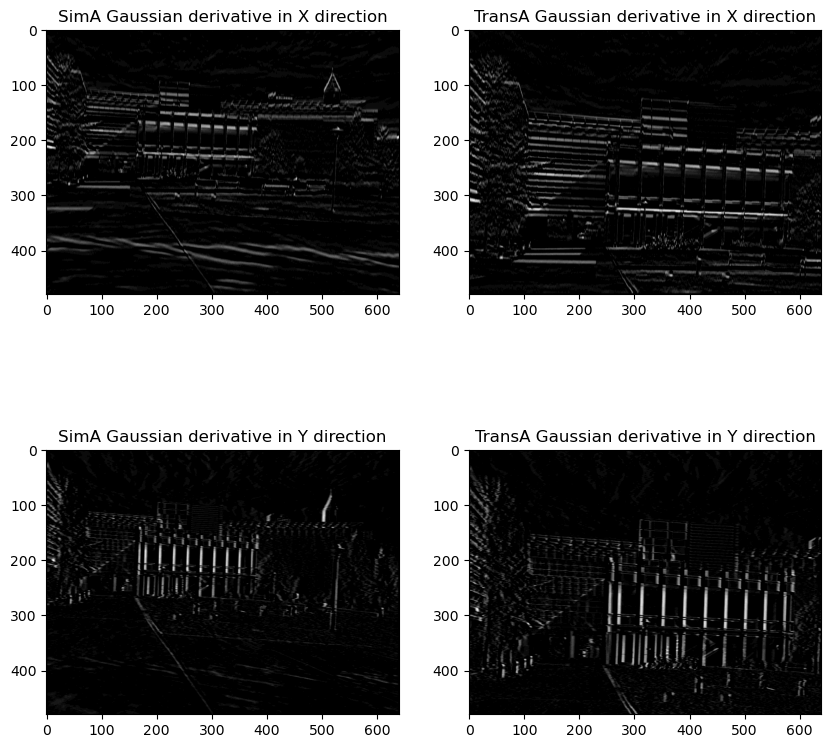

In [5]:
#Apply gaussian derivatives in X and Y directions to the image
simA=cv2.imread('simA.jpg',0)
transA=cv2.imread('transA.jpg',0)
simB=cv2.imread('simB.jpg',0)
transB=cv2.imread('transB.jpg',0)

#Gaussian derivative in X direction
sigma=3
kernel_size=9
simA_gaussian_derivative_x=gaussian_derivative_x(simA,sigma,kernel_size)
transA_gaussian_derivative_x=gaussian_derivative_x(transA,sigma,kernel_size)
simA_gaussian_derivative_y=gaussian_derivative_y(simA,sigma,kernel_size)
transA_gaussian_derivative_y=gaussian_derivative_y(transA,sigma,kernel_size)

#Plot the results
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(simA_gaussian_derivative_x,cmap='gray')
plt.title('SimA Gaussian derivative in X direction')
plt.subplot(222)
plt.imshow(transA_gaussian_derivative_x,cmap='gray')
plt.title('TransA Gaussian derivative in X direction')
plt.subplot(223)
plt.imshow(simA_gaussian_derivative_y,cmap='gray')
plt.title('SimA Gaussian derivative in Y direction')
plt.subplot(224)
plt.imshow(transA_gaussian_derivative_y,cmap='gray')
plt.title('TransA Gaussian derivative in Y direction')
plt.show()


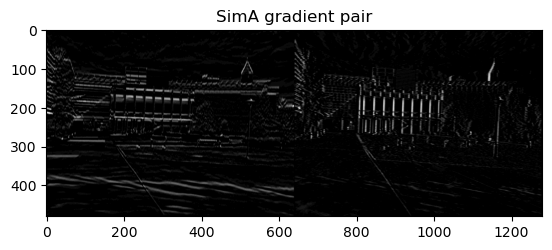

In [6]:
#Gradient pair for simA
simA_gradient_pair=np.zeros((simA.shape[0],simA.shape[1]*2))
simA_gradient_pair[:,0:simA.shape[1]]=simA_gaussian_derivative_x
simA_gradient_pair[:,simA.shape[1]:]=simA_gaussian_derivative_y
plt.imshow(simA_gradient_pair,cmap='gray')
plt.title('SimA gradient pair')
plt.show()

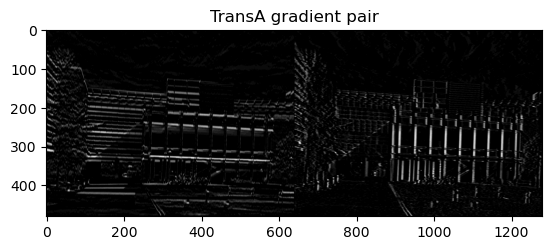

In [7]:
#Gradient pair for transA
transA_gradient_pair=np.zeros((transA.shape[0],transA.shape[1]*2))
transA_gradient_pair[:,0:transA.shape[1]]=transA_gaussian_derivative_x
transA_gradient_pair[:,transA.shape[1]:]=transA_gaussian_derivative_y
plt.imshow(transA_gradient_pair,cmap='gray')
plt.title('TransA gradient pair')
plt.show()


1.2 Write code to compute the Harris value. You can try the weights just equal to 1. But it might
work better with a smoother Gaussian that is higher at the middle and falls off gradually.
Your output is a scalar function.

In [8]:
#R=det(M)-alfa*trace(M)^2
#M=[Ix^2 IxIy;IxIy Iy^2]
alfa=0.05
def Harris(Ix,Iy,alfa):
    Ix2=Ix**2
    Iy2=Iy**2
    IxIy=Ix*Iy
    detM=Ix2*Iy2
    traceM=Ix2+Iy2
    R=detM-alfa*traceM**2

    return R
    



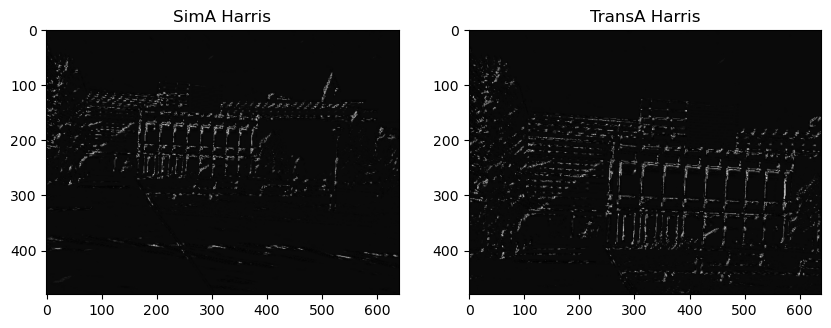

In [9]:
R_simA=Harris(simA_gaussian_derivative_x,simA_gaussian_derivative_y,alfa)
R_transA=Harris(transA_gaussian_derivative_x,transA_gaussian_derivative_y,alfa)

simB_gaussian_derivative_x=gaussian_derivative_x(simB,sigma,kernel_size)
simB_gaussian_derivative_y=gaussian_derivative_y(simB,sigma,kernel_size)
R_simB=Harris(simB_gaussian_derivative_x,simB_gaussian_derivative_y,alfa) 

transB_gaussian_derivative_x=gaussian_derivative_x(transB,sigma,kernel_size)
transB_gaussian_derivative_y=gaussian_derivative_y(transB,sigma,kernel_size)
R_transB=Harris(transB_gaussian_derivative_x,transB_gaussian_derivative_y,alfa)

R_simA = cv2.normalize(R_simA, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
R_transA = cv2.normalize(R_transA, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
R_simB=cv2.normalize(R_simB, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
R_transB=cv2.normalize(R_transB, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

#Plot the results
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(R_simA,cmap='gray')
plt.title('SimA Harris')
plt.subplot(222)
plt.imshow(R_transA,cmap='gray')
plt.title('TransA Harris')
plt.show()





1.3 Write a function to threshold and do non-maximal suppression on the Harris output. Surprise,
huh? Adjust the threshold and radius until you get a “nice” set of points, probably on the
order of a hundred or two (or three?). But use your judgment in terms of getting enough
points. Are there any points that are not found in both images?
Output: The code. Apply your function to both image pair: (transA, transB) and (simA,
simB). Mark the corners visibly in each of the four result images and provide those images.
Also, describe the behavior of your corner detector including anything surprising, such as
points not found in both images of a pair

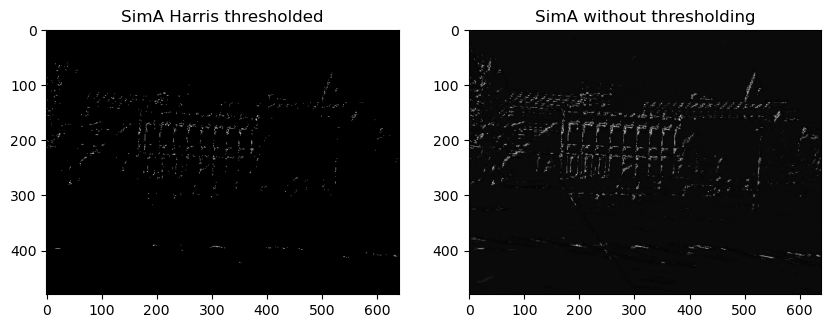

In [11]:
#Thresholding
def thresholding(R,threshold):
    R_thresholded=np.copy(R)
    R_thresholded[R < threshold] = 0
    return R_thresholded

threshold=int(255*0.6)
R_simA_thresholded=thresholding(R_simA,threshold)
R_simB_thresholded=thresholding(R_simB,threshold)
R_transA_thresholded=thresholding(R_transA,threshold)
R_transB_thresholded=thresholding(R_transB,threshold)

#Plot the results
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(R_simA_thresholded,cmap='gray')
plt.title('SimA Harris thresholded')
plt.subplot(222)
plt.imshow(R_simA,cmap='gray')
plt.title('SimA without thresholding')
plt.show()


In [12]:
#Non-maximal suppression
def non_maximal_suppression(R, radius):
    R_nms = np.zeros_like(R)
    for i in range(radius, R.shape[0]-radius):
        for j in range(radius, R.shape[1]-radius):
            if R[i,j] != 0:
                max_val = np.max(R[i-radius:i+radius+1, j-radius:j+radius+1])
                if R[i,j] == max_val:
                    R_nms[i,j] = R[i,j]
    return R_nms


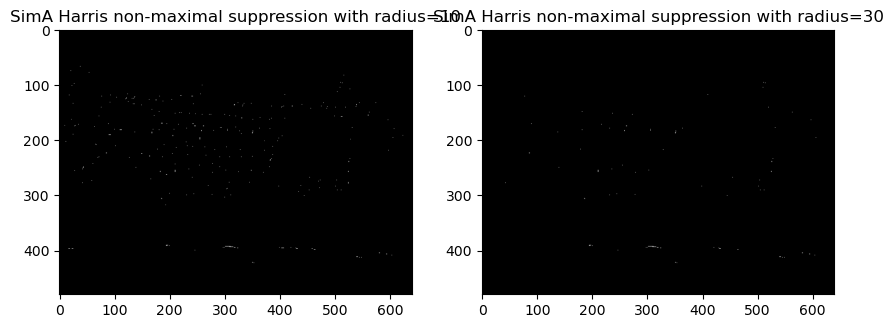

In [13]:
#Comparison between different radius values
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(non_maximal_suppression(R_simA_thresholded,10),cmap='gray')
plt.title('SimA Harris non-maximal suppression with radius=10')
plt.subplot(222)
plt.imshow(non_maximal_suppression(R_simA_thresholded,30),cmap='gray')
plt.title('SimA Harris non-maximal suppression with radius=30')
plt.show()

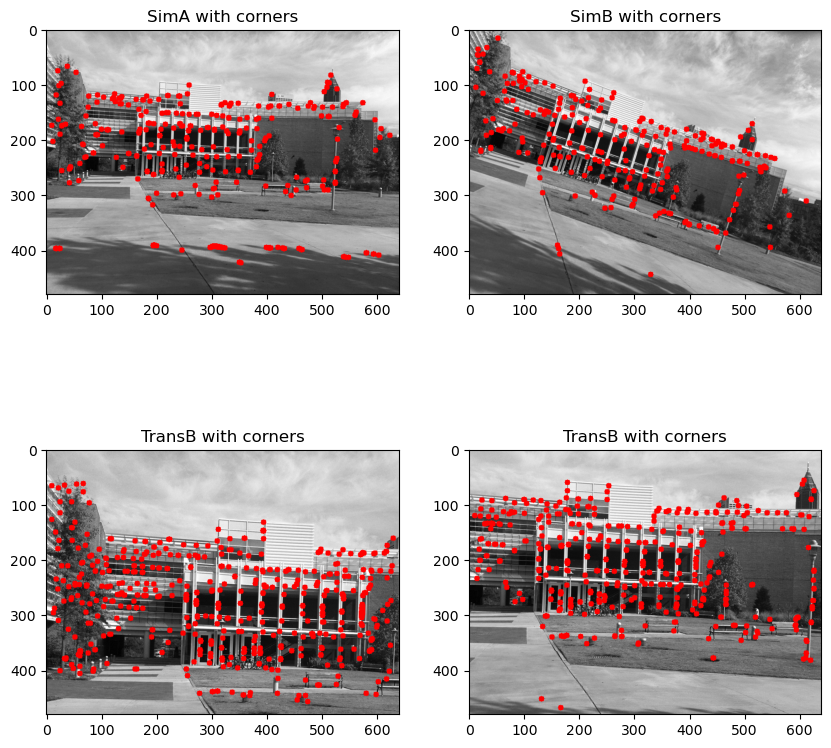

In [14]:
radius=10
R_simA_non_maximal_suppression = non_maximal_suppression(R_simA_thresholded, radius)
simA_with_corners = cv2.cvtColor(simA, cv2.COLOR_GRAY2RGB)
for i in range(R_simA_non_maximal_suppression.shape[0]):
    for j in range(R_simA_non_maximal_suppression.shape[1]):
        if R_simA_non_maximal_suppression[i,j] != 0:
            cv2.circle(simA_with_corners, (j,i), radius=5, color=(255,0,0), thickness=-1)


R_simB_non_maximal_suppression = non_maximal_suppression(R_simB_thresholded, radius)
simB_with_corners = cv2.cvtColor(simB, cv2.COLOR_GRAY2RGB)
for i in range(R_simB_non_maximal_suppression.shape[0]):
    for j in range(R_simB_non_maximal_suppression.shape[1]):
        if R_simB_non_maximal_suppression[i,j] != 0:
            cv2.circle(simB_with_corners, (j,i), radius=5, color=(255,0,0), thickness=-1)

R_transA_non_maximal_suppression = non_maximal_suppression(R_transA_thresholded, radius)
transA_with_corners = cv2.cvtColor(transA, cv2.COLOR_GRAY2RGB)
for i in range(R_transA_non_maximal_suppression.shape[0]):
    for j in range(R_transA_non_maximal_suppression.shape[1]):
        if R_transA_non_maximal_suppression[i,j] != 0:
            cv2.circle(transA_with_corners, (j,i), radius=5, color=(255,0,0), thickness=-1)

R_transB_non_maximal_suppression = non_maximal_suppression(R_transB_thresholded, radius)
transB_with_corners = cv2.cvtColor(transB, cv2.COLOR_GRAY2RGB)
for i in range(R_transB_non_maximal_suppression.shape[0]):
    for j in range(R_transB_non_maximal_suppression.shape[1]):
        if R_transB_non_maximal_suppression[i,j] != 0:
            cv2.circle(transB_with_corners, (j,i), radius=5, color=(255,0,0), thickness=-1)

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(simA_with_corners)
plt.title('SimA with corners')
plt.subplot(222)
plt.imshow(simB_with_corners)
plt.title('SimB with corners')
plt.subplot(223)
plt.imshow(transA_with_corners)
plt.title('TransB with corners')
plt.subplot(224)
plt.imshow(transB_with_corners)
plt.title('TransB with corners')
plt.show()

Depending on the chosen parameters for the radius and threshold, a different amount of points are found. The detected corners look good, however, there are obvious corners that have not been detected in an image, but they have been detected in the other one. I also find surprising that no corners have been detected in the clouds, where could be gradient in all directons due to sharpe changes within the clouds.

2.1 SIFT. Write the function to compute the angle. Then for the set of interest points you found above,
plot the points for all of transA, transB, simA and simB on the respective images and draw
a little line that shows the direction of the gradient. In OpenCV you can use the method drawKeypoints().

In [15]:
#Angle image
def angle_image(Ix,Iy):
    angle=np.arctan2(Iy,Ix)
    return angle


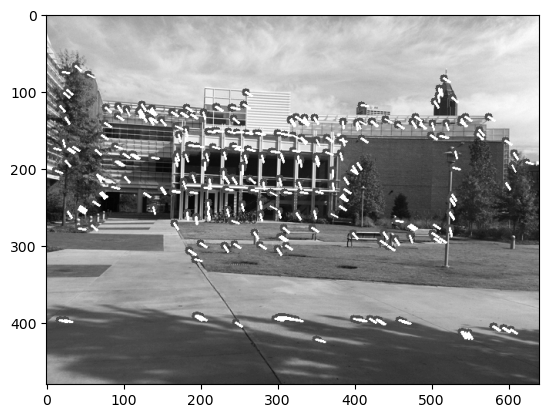

In [16]:
#SimA image
angle_simA=angle_image(simA_gaussian_derivative_x,simA_gaussian_derivative_y)
simA_with_orientation = cv2.cvtColor(simA_with_corners, cv2.COLOR_RGB2GRAY)
for i in range(R_simA_non_maximal_suppression.shape[0]):
    for j in range(R_simA_non_maximal_suppression.shape[1]):
        if R_simA_non_maximal_suppression[i,j] != 0:
            cv2.line(simA_with_orientation, (j,i), (int(j+10*np.cos(angle_simA[i,j])),int(i+10*np.sin(angle_simA[i,j]))), color=(255,255,255), thickness=2)

plt.imshow(simA_with_orientation,cmap='gray')

2.2 Write the function to call the appropriate SIFT descriptor extraction function with the necessary input data structures. Do this for all the keypoints in both pairs of images. Then call the matching functions of VLFeat or OpenCV to compute the best matches between the left and right images of each pair. Then create the putative-pair-image for both transA–transB and simA–simB pair. You must write your own drawing function (note you may use OpenCV’s line() function or MATLAB’s plot() function).

In [18]:
def sift(img1,img2,dis):
   # Initiate SIFT detector
   sift = cv2.SIFT_create()
   # find the keypoints and descriptors with sift
   kp1, des1 = sift.detectAndCompute(img1,None)
   kp2, des2 = sift.detectAndCompute(img2,None)

   # BFMatcher with default params
   bf = cv2.BFMatcher()
   matches = bf.knnMatch(des1,des2,k=2)
   # Apply ratio test
   good = []
   for m,n in matches:
      if m.distance < dis*n.distance:
         good.append([m])

   # create a new figure
   fig, ax = plt.subplots()

   # plot the two images side by side
   ax.imshow(np.hstack((img1, img2)), cmap='gray')

   # iterate through the good matches and draw lines between the corresponding keypoints
   img1_features = []
   img2_features = []
   for match in good:
      # get the index of the keypoint in img1 and img2
      idx1 = match[0].queryIdx
      idx2 = match[0].trainIdx
      
      # get the x, y coordinates of the keypoints in img1 and img2
      x1, y1 = kp1[idx1].pt
      x2, y2 = kp2[idx2].pt
      
      # shift the x coordinate of the keypoints in img2 by the width of img1
      x2 += img1.shape[1]
      
      # draw a line between the keypoints
      ax.plot([x1, x2], [y1, y2], 'r-', linewidth=0.25)
      
      # add the keypoints to the features arrays
      img1_features.append(kp1[idx1])
      img2_features.append(kp2[idx2])
      
   # sort the features arrays so that each element of the arrays match
   img1_features, img2_features = zip(*sorted(zip(img1_features, img2_features), key=lambda x: x[0].response, reverse=True))
   
   # show the plot
   plt.show()
   
   return img1_features, img2_features
    


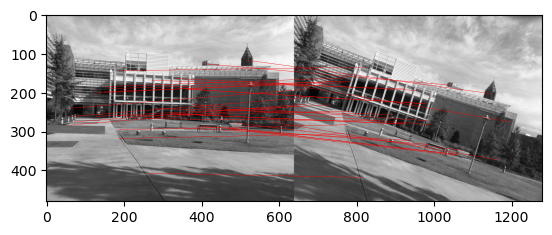

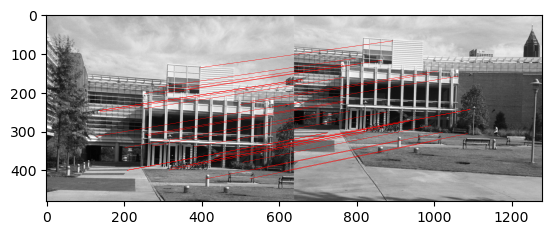

In [19]:
simA_gray = cv2.imread('simA.jpg',cv2.IMREAD_GRAYSCALE) 
simB_gray = cv2.imread('simB.jpg',cv2.IMREAD_GRAYSCALE) 
transA_gray = cv2.imread('transA.jpg',cv2.IMREAD_GRAYSCALE)
transB_gray = cv2.imread('transB.jpg',cv2.IMREAD_GRAYSCALE)
dis=0.15

[simA_feat, simB_feat]=sift(simA_gray,simB_gray,dis)
[transA_feat,transB_feat]=sift(transA_gray,transB_gray,dis)


3. RANSAC

We’re almost there. You now have keypoints, descriptors and their putative matches. What remains
is RANSAC. To do this for the translation case is easy. Using the matched keypoints for transA
and transB, randomly select one of the putative matches. This will give you an offset (a translation
in X and Y ) between the two images. Find out how many other putative matches agree with this
offset (remember, you may have to account for noise, so ”agreeing” means within some tolerance).
This is the consensus set for the selected first match. Find the best such translation - the one with
the biggest consensus set.

3.1 Write the code to do the translational case on transA and transB. Draw the lines on the
adjoined images of the biggest consensus set.

In [20]:
# get the x, y coordinates of the first keypoint in transA_feat and transB_feat

# set the tolerance for agreeing matches
tolerance = 10

# set the number of iterations for RANSAC
num_iterations = 1000

# initialize the best translation and the size of the consensus set
best_tx = 0
best_ty = 0
best_consensus_set_size = 0

# iterate through the number of iterations for RANSAC
for i in range(num_iterations):
    # randomly select one of the putative matches
    idx = random.randint(0, len(transA_feat)-1)
    x1, y1 = transA_feat[idx].pt
    x2, y2 = transB_feat[idx].pt

    # compute the translation between the two images
    tx = x2 - x1
    ty = y2 - y1

    # initialize the consensus set
    consensus_set = []

    # iterate through all the putative matches
    for j in range(len(transA_feat)):
        x1, y1 = transA_feat[j].pt
        x2, y2 = transB_feat[j].pt

        # compute the distance between the two keypoints after applying the translation
        dist = ((x2 - x1 - tx)**2 + (y2 - y1 - ty)**2)**0.5

        # if the distance is within the tolerance, add the match to the consensus set
        if dist < tolerance:
            consensus_set.append(j)

    # if the size of the consensus set is bigger than the previous best, update the best translation and the size of the consensus set
    if len(consensus_set) > best_consensus_set_size:
        best_tx = tx
        best_ty = ty
        best_consensus_set_size = len(consensus_set)

# print the best translation and the size of the consensus set
print("Best translation: ({}, {})".format(best_tx, best_ty))
print("Consensus set percentage: {}".format(best_consensus_set_size*100/len(transA_feat)))



Best translation: (-130.2452392578125, -90.06187438964844)
Consensus set percentage: 25.0


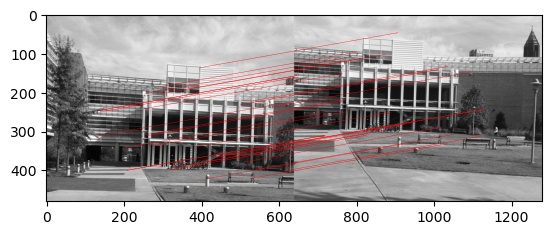

In [21]:
# create a new figure
fig, ax = plt.subplots()

# adjoin the two images
adjoined = np.hstack((transA_gray, transB_gray))

# iterate through all the putative matches
for j in range(len(transA_feat)):
    x1, y1 = transA_feat[j].pt
    x2, y2 = transB_feat[j].pt
   

    ax.plot([x1, x1+best_tx+transA_gray.shape[1]], [y1, y1+best_ty], 'r-', linewidth=0.25)

# show the adjoined images with the lines drawn
ax.imshow(adjoined, cmap='gray')
plt.show()


3.2 Similarity transform. Do the same as above but for the similarity pair simA and simB. Write code to apply RANSAC
by randomly picking two matches, solving for the transform, and determining the consensus
set. Draw the lines on the adjoined images for the biggest consensus set.

In [23]:
def solve_svd(A,b):
    # compute svd of A
    U,s,Vh = svd(A)

    # U diag(s) Vh x = b <=> diag(s) Vh x = U.T b = c
    c = np.dot(U.T,b)
    # diag(s) Vh x = c <=> Vh x = diag(1/s) c = w (trivial inversion of a diagonal matrix)
    w = np.dot(np.diag(1/s),c)
    # Vh x = w <=> x = Vh.H w (where .H stands for hermitian = conjugate transpose)
    x = np.dot(Vh.conj().T,w)
    return x

In [34]:
# set the tolerance for agreeing matches
tolerance = 6

# set the number of iterations for RANSAC
num_iterations = 1000

# initialize the best transform and the size of the consensus set
best_transform = None
best_consensus_set_size = 0

# iterate through the number of iterations for RANSAC
for i in range(num_iterations):
    # randomly select two of the putative matches
    idx1, idx2 = random.sample(range(len(simA_feat)), 2)
    u1, v1 = simA_feat[idx1].pt
    u_prime1, v_prime1 = simB_feat[idx1].pt
    u2, v2 = simA_feat[idx2].pt
    u_prime2, v_prime2 = simB_feat[idx2].pt

    # compute the transform between the two images
    A=np.array([[u1,-v1,1,0],[v1,u1,0,1],[u2,-v2,1,0],[v2,u2,0,1]])
    b=np.array([u_prime1,v_prime1,u_prime2,v_prime2])
    x=solve_svd(A,b)
    transform=np.array([[x[0],-x[1],x[2]],[x[1],x[0],x[3]]])

    

    # initialize the consensus set
    consensus_set = []

    # iterate through all the putative matches
    for j in range(len(simA_feat)):
        x1, y1 = simA_feat[j].pt
        x2, y2 = simB_feat[j].pt

        # compute the distance between the two keypoints after applying the transform
        p1 = np.array([x1, y1, 1])
        p2 = np.array([x2, y2])
        p2_transformed = np.dot(transform, p1)
        dist = np.linalg.norm(p2 - p2_transformed)

        # if the distance is within the tolerance, add the match to the consensus set
        if dist < tolerance:
            consensus_set.append(j)

    # if the size of the consensus set is bigger than the previous best, update the best transform and the size of the consensus set
    if len(consensus_set) > best_consensus_set_size:
        best_transform = transform
        best_consensus_set_size = len(consensus_set)

# print the best transform and the size of the consensus set
print("Best transform:")
print(best_transform)
print("Consensus set percentage: {}".format(best_consensus_set_size*100/len(simA_feat)))


C:\Users\richi\AppData\Local\Temp\ipykernel_2096\3997233702.py:8: RuntimeWarning: divide by zero encountered in divide
  w = np.dot(np.diag(1/s),c)


Best transform:
[[  0.9756844   -0.27461941  36.55373611]
 [  0.27461941   0.9756844  -55.41769737]]
Consensus set percentage: 97.05882352941177


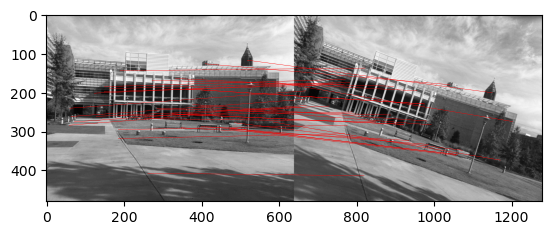

In [36]:
# create a new figure
fig, ax = plt.subplots()

# adjoin the two images
adjoined = np.hstack((simA_gray, simB_gray))

for i in range(len(simA_feat)):
    u1, v1 = simA_feat[i].pt
    u_prime1, v_prime1 = simB_feat[i].pt
    u2, v2 = simA_feat[i].pt
    u_prime2, v_prime2 = simB_feat[i].pt

    

    p1 = np.array([u1, v1, 1])
    p2_transformed = np.dot(best_transform, p1)


    ax.plot([u1, p2_transformed[0]+simA_gray.shape[1]], [v1, p2_transformed[1]], 'r-', linewidth=0.25)

# show the adjoined images with the lines drawn
ax.imshow(adjoined, cmap='gray')
plt.show()